## Create the figures used in Stochastic Variance Reduced Gradient Plug-and-Play Methods for Solving Image Reconnstruction Problems (ICIP 2021)

In [1]:
%matplotlib inline 

# from imports import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from algorithms import *
from Utilities import display_results
import sys
sys.path.append('problems/')
sys.path.append('denoisers/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from problems.DeblurSR import Deblur
from denoisers.BM3D import BM3DDenoiser

# Figures 1: Compare Image Fidelity for Different Algorithms 

In [3]:
height, width = 256, 256
rescale = 100
snr = 5.

main_problem = Deblur(img_path='./data/Set12/01.png', kernel="Minimal", H=height, W=width, snr=snr, scale_percent=rescale)
print(main_problem.sigma, main_problem.M)
print(main_problem.Y)

0.0015155036596592854 65536
[0.00130534 0.0009748  0.00464315 ... 0.00317353 0.00366271 0.00178943]


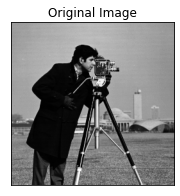

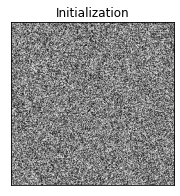

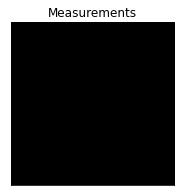

In [4]:
main_problem.display(show_measurements=True, save_results=True)

In [5]:
denoiser = BM3DDenoiser()
results_svrg = pnp_svrg(main_problem, denoiser=denoiser, eta=1e7, tt=60, T2=10, mini_batch_size=100, verbose=True)

0 0 Before denoising:  8.267916540959694
After denoising update: 0 0 11.804304084478925
0 1 Before denoising:  11.80980558755638
After denoising update: 0 1 11.810441481572898
0 2 Before denoising:  11.815907904898893
After denoising update: 0 2 11.815889872714802
0 3 Before denoising:  11.821912442719618
After denoising update: 0 3 11.821871929349491
0 4 Before denoising:  11.826911439905668
After denoising update: 0 4 11.826874303494963
0 5 Before denoising:  11.832294479573838
After denoising update: 0 5 11.832298098122306
0 6 Before denoising:  11.837234667595897


KeyboardInterrupt: 

In [ ]:
master_psnr_fig = display_results(main_problem, results_svrg, save_results=True)

# Figure 2(a): Compare PSNR over time using NLM

In [ ]:
# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig = plt.figure(figsize=(8,8))
psnr_ax = psnr_fig.add_subplot(1, 1, 1)

psnr_ax.plot(np.cumsum(time_SVRG_1), psnr_SVRG_1,"b", linewidth=3)
psnr_ax.plot(np.cumsum(time_GD_1), psnr_GD_1,"g", linewidth=3)
psnr_ax.plot(np.cumsum(time_SGD_1), psnr_SGD_1,"r", linewidth=3)

psnr_ax.plot(np.cumsum(time_SVRG_1)[::30], psnr_SVRG_1[::30],"b*", markersize=10)
psnr_ax.plot(np.cumsum(time_GD_1)[::100], psnr_GD_1[::100],"gv", markersize=10)
psnr_ax.plot(np.cumsum(time_SGD_1)[::100], psnr_SGD_1[::100],"rs", markersize=10)

psnr_ax.set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax.legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD'), loc='lower right')
psnr_ax.grid()

psnr_fig.tight_layout()

plt.savefig("./figures/csmri/psnr_over_time/psnr_over_time.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()




## Figure 2(b): Compare Sampling Ratio for each PnP Algorithm

In [ ]:
num_probs = 20
num_trials = 3
sample_probs = np.linspace(.1, 1, num_probs)

prob_vs_psnr_SVRG = []
prob_vs_psnr_GD = []
prob_vs_psnr_SGD = []

for i in range(num_probs):
    samp_ratio_SVRG = []
    samp_ratio_GD = []
    samp_ratio_SGD = []
    samp_ratio_LSVRG = []
    for j in range(num_trials):
        samp_ratio_problem = create_problem('./data/Set12/13.png', H=256, W=256, sigma=5, sample_prob=sample_probs[i])
        
        z_SVRG, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(samp_ratio_problem, denoiser=denoiser, eta=2000, tt=200, T2=30, mini_batch_size=1000, verbose=True)
        samp_ratio_SVRG.append(psnr_SVRG[-1])

        z_GD, time_GD, psnr_GD, zs_GD = pnp_gd(samp_ratio_problem, denoiser=denoiser, eta=2000, tt=200, verbose=True)
        samp_ratio_GD.append(psnr_GD[-1])

        z_SGD, time_SGD, psnr_SGD, zs_SGD = pnp_sgd(samp_ratio_problem, denoiser=denoiser, eta=1500, tt=200, mini_batch_size=5000, verbose=True)
        samp_ratio_SGD.append(psnr_SGD[-1])
    prob_vs_psnr_SVRG.append(np.average(samp_ratio_SVRG))
    prob_vs_psnr_GD.append(np.average(samp_ratio_GD))
    prob_vs_psnr_SGD.append(np.average(samp_ratio_SGD))


In [ ]:
# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig = plt.figure(figsize=(8,8))
psnr_ax = psnr_fig.add_subplot(1, 1, 1)

psnr_ax.plot(sample_probs, prob_vs_psnr_SVRG, "b*-")
psnr_ax.plot(sample_probs, prob_vs_psnr_GD, "gv-")
psnr_ax.plot(sample_probs, prob_vs_psnr_SGD, "rs-")


psnr_ax.set(xlabel='sampling rate (p = m/n)', ylabel='PSNR (dB)')
psnr_ax.legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD'), loc='lower right')
psnr_ax.grid()
plt.xlim(0.1, 1.0)
psnr_fig.tight_layout()

plt.savefig("./figures/csmri/samp_ratio/samp_ratio.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()

In [ ]:
with open('fig4.pkl', 'wb') as f:  
    pickle.dump([samp_ratio_problem, sample_probs, prob_vs_psnr_SVRG, prob_vs_psnr_GD, prob_vs_psnr_SGD], f)

## Figure 3: Compare Image Denoising Routines with PnP-SVRG using RGB Images

In [ ]:
img=np.array(Image.open('./data/Set12/image.png').resize((256,256)), dtype=int)
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
slice0 = img[:,:,0]
slice1 = img[:,:,1]
slice2 = img[:,:,2]

np.random.seed(0)
slice0_res = CSMRI(img=img[:,:,0], H=256, W=256, sigma=5, sample_prob=0.5)
np.random.seed(0)
slice1_res = CSMRI(img=img[:,:,1], H=256, W=256, sigma=5, sample_prob=0.5)
np.random.seed(0)
slice2_res = CSMRI(img=img[:,:,2], H=256, W=256, sigma=5, sample_prob=0.5)

noisy = np.zeros((256,256,3), 'float')
noisy[:, :, 0] = slice0_res.noisy
noisy[:, :, 1] = slice1_res.noisy
noisy[:, :, 2] = slice2_res.noisy

imgplot = plt.imshow(noisy)
plt.title("BM3D, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, noisy))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
denoiser = CNNDenoiser(device=device, cnn_decay=0.99)
np.random.seed(0)
z_slice0_cnn, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice0_res, denoiser=denoiserCNN, eta=13000, tt=20, T2=5, mini_batch_size=2000, verbose=True)
z_slice1_cnn, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice1_res, denoiser=denoiserCNN, eta=13000, tt=20, T2=5, mini_batch_size=2000, verbose=True)
z_slice2_cnn, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice2_res, denoiser=denoiserCNN, eta=13000, tt=20, T2=5, mini_batch_size=2000, verbose=True)

In [ ]:
denoised_cnn = np.zeros((256,256,3), 'float')
denoised_cnn[..., 0] = z_slice0_cnn
denoised_cnn[..., 1] = z_slice1_cnn
denoised_cnn[..., 2] = z_slice2_cnn

imgplot = plt.imshow(denoised_cnn)
plt.title("CNN, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_cnn))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
denoiserBM3D = BM3DDenoiser(noise_est=1.5, filter_decay=0.9)
np.random.seed(0)
z_slice0_bm3d, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice0_res, denoiser=denoiserBM3D, eta=10000, tt=100, T2=5, mini_batch_size=2000, verbose=True)
z_slice1_bm3d, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice1_res, denoiser=denoiserBM3D, eta=10000, tt=100, T2=5, mini_batch_size=2000, verbose=True)
z_slice2_bm3d, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice2_res, denoiser=denoiserBM3D, eta=10000, tt=100, T2=5, mini_batch_size=2000, verbose=True)

In [ ]:
denoised_bm3d = np.zeros((256,256,3), 'float')
denoised_bm3d[..., 0] = z_slice0_bm3d
denoised_bm3d[..., 1] = z_slice1_bm3d
denoised_bm3d[..., 2] = z_slice2_bm3d

imgplot = plt.imshow(denoised_bm3d)
plt.title("BM3D, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_bm3d))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
denoiserTV = TVDenoiser()
np.random.seed(0)
z_slice0_tv, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice0_res, denoiser=denoiserTV, eta=11000, tt=100, T2=5, mini_batch_size=2000, verbose=True)
z_slice1_tv, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice1_res, denoiser=denoiserTV, eta=11000, tt=100, T2=5, mini_batch_size=2000, verbose=True)
z_slice2_tv, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice2_res, denoiser=denoiserTV, eta=11000, tt=100, T2=5, mini_batch_size=2000, verbose=True)

In [ ]:
denoised_tv = np.zeros((256,256,3), 'float')
denoised_tv[..., 0] = z_slice0_tv
denoised_tv[..., 1] = z_slice1_tv
denoised_tv[..., 2] = z_slice2_tv

imgplot = plt.imshow(denoised_tv)
plt.title("Wavelet, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_tv))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
denoiserNLM = NLMDenoiser(filter_decay=0.95, filter_size=1.0, patch_size=5, patch_distance=6)
np.random.seed(0)
z_slice0_nlm, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice0_res, denoiser=denoiserNLM, eta=10000, tt=50, T2=5, mini_batch_size=2000, verbose=True)
z_slice1_nlm, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice1_res, denoiser=denoiserNLM, eta=10000, tt=50, T2=5, mini_batch_size=2000, verbose=True)
z_slice2_nlm, time_SVRG, psnr_SVRG, zs_SVRG = pnp_svrg(slice2_res, denoiser=denoiserNLM, eta=10000, tt=50, T2=5, mini_batch_size=2000, verbose=True)

In [ ]:
denoised_nlm = np.zeros((256,256,3), 'float')
denoised_nlm[..., 0] = z_slice0_nlm
denoised_nlm[..., 1] = z_slice1_nlm
denoised_nlm[..., 2] = z_slice2_nlm

imgplot = plt.imshow(denoised_nlm)
plt.title("NLM, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_nlm))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
fig = plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.title.set_text('Original')
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/superres/compare_denoisers/orig.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig = plt.figure(figsize=(3,3))
plt.imshow(noisy, cmap='gray', vmin=0, vmax=1)
plt.title.set_text("Initial Estimate, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, noisy))
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/superres/compare_denoisers/noisy.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig = plt.figure(figsize=(3,3))
plt.imshow(denoised_nlm, cmap='gray', vmin=0, vmax=1)
plt.title.set_text("NLM, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_nlm))
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/superres/compare_denoisers/nlm.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig = plt.figure(figsize=(3,3))
plt.imshow(denoised_tv, cmap='gray', vmin=0, vmax=1)
plt.title.set_text("Wavelet, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_tv))
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/superres/compare_denoisers/tv.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig = plt.figure(figsize=(3,3))
plt.imshow(denoised_bm3d, cmap='gray', vmin=0, vmax=1)
plt.title.set_text("BM3D, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_bm3d))
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/superres/compare_denoisers/bm3d.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig = plt.figure(figsize=(3,3))
plt.imshow(denoised_cnn, cmap='gray', vmin=0, vmax=1)
plt.title.set_text("CNN, PSNR %.2f" % peak_signal_noise_ratio(img[...,0:3].astype('float')/256, denoised_cnn))
plt.xticks([])
plt.yticks([])
plt.savefig("./figures/superres/compare_denoisers/cnn.eps", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
with open('fig3.pkl', 'wb') as f:  
    pickle.dump([params, z_SVRG_nlm, z_SVRG_tv, z_SVRG_bm3d, z_SVRG_cnn], f)